# Etude préliminaire valeurs mesurées en laboratoire différentes pour un même prélèvement


## Contexte
Ce Notebook vise à avancer sur la tâche 179 [définie ici](https://noco.services.dataforgood.fr/dashboard/#/nc/pk1vq1pm8frc5lm/ms9uz8er4jpow7j/Kanban%20data%20analyst?rowId=179), à savoir : 

* Table edc_resultats, il y a une colonne referenceanl
* La documentation PDF dit : Identifiant de l’analyse réalisée en laboratoire ; il s’agit d’un numéro attribué par le système garantissant son unicité.

  Un prélèvement peut faire l’objet d’une analyse sur le terrain (InSituAna=T) et/ou d’une ou plusieurs analyses en laboratoire (InSituAna=L).

  Un même paramètre peut donc être analysé sur le terrain, et dans le cadre d’une ou plusieurs analyses par des laboratoires différents.

* Ca veut dire qu'il peut y avoir deux analyses par deux laboratoires qui trouvent des résultats contradictoires ?

Choses à faire : explorer :)

## Méthodologie

L'étude n'a pas prétention à l'exhaustivité.

En particulier, on ne considère que les catégories qui nous intéressent : pesticides, métabolite de pesticide, nitrite, pfas, cvm, perchlorate.

La vue `int__resultats_udi_communes` n'a pas de colonne `referenceanl` donc on repart des catégories dans `from mapping_categories` et de `edc_resultats`.

C'est parti...



In [1]:
import pandas as pd
import duckdb
from pipelines.tasks.config.common import DUCKDB_FILE

pd.set_option("display.max_columns", None)  # show all cols
con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

con.execute("describe tables").df()

,name
0,ana__resultats_communes
1,atlasante_udi
2,cog_communes
3,edc_communes
4,edc_prelevements
5,edc_resultats
6,int__lien_cdreseau_refreneceprel
7,int__lien_commune_cdreseau
8,int__mapping_category_simple
9,int__prelevements_uniques


In [2]:
dfmap = con.execute("from mapping_categories").df()
dfmap

,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,casparam,categorie
0,PESTOT,6276,TOTAL DES PESTICIDES ANALYSÉS,Total des pesticides analysés,None,pesticides
1,ATRZ,1107,ATRAZINE,Atrazine,1912-24-9,pesticides
2,SMZ,1263,SIMAZINE,Simazine,122-34-9,pesticides
3,MTC,1221,MÉTOLACHLORE,Métolachlore,51218-45-2,pesticides
4,TBZ,1268,TERBUTHYLAZIN,Terbuthylazin,5915-41-3,pesticides
...,...,...,...,...,...,...
1607,TC2P,7850,"1,1,1-TRICHLORO-2-PROPANONE","1,1,1-trichloro-2-propanone",918-00-3,non classé
1608,BDE183,2910,HEPTABROMODIPHÉNYL ÉTHER (CONGÉNÈRE,Heptabromodiphényl éther (congénère 183),207122-16-5,non classé
1609,PBDE1,1921,PENTABROMODIPHÉNYLÉTHER,Pentabromodiphényléther,32534-81-9,non classé
1610,DEGBE,2641,BUTYL CARBITOL,Butyl carbitol,112-34-5,non classé


In [3]:
dfmap.categorie.drop_duplicates().to_list()

['pesticides',
 'métabolite de pesticide',
 'nitrite',
 'pfas',
 'cvm',
 'sous produit désinfection',
 'perchlorate',
 'métaux lourds',
 'hydrocarbures',
 'non classé',
 'hap',
 'pcb',
 'dioxine et furane',
 'phtalate',
 'phénol',
 'médicament',
 'paramètre organoleptique',
 'minéral',
 'microbio',
 'radioactivité']

In [4]:
nos_categories = [
    "pesticides",
    "métabolite de pesticide",
    "nitrite",
    "pfas",
    "cvm",
    "perchlorate",
]
sel_sise = (
    dfmap[dfmap.categorie.isin(nos_categories)]["cdparametresiseeaux"]
    .drop_duplicates()
    .to_list()
)
sel_sise[:15]

['PESTOT',
 'ATRZ',
 'SMZ',
 'MTC',
 'TBZ',
 'METZCL',
 'MTBZ',
 'MTMI',
 'ALCL',
 'TERBU',
 'DIU',
 'CTOL',
 'HXZN',
 'ISP',
 'BTZ']

In [5]:
edc_res = con.table("edc_resultats")
goodcol = [
    "referenceprel",
    "referenceanl",
    "cdparametresiseeaux",
    "valtraduite",
    "insituana",
]
edc_col = con.sql(f"FROM edc_resultats SELECT DISTINCT {','.join(goodcol)}")

## Sanity check : insituana=L <=> referenceanl existe
On s'assure que si insituana est à "L" il y a une référence ANL, et réciproquement qu'une référence ANL implique insituana à "L" (et pas à T) :

In [6]:
con.sql(
    "FROM edc_col WHERE (referenceanl IS NULL AND insituana = 'L') OR (referenceanl IS NOT NULL AND insituana <> 'L')"
).show()

┌───────────────┬──────────────┬─────────────────────┬─────────────┬───────────┐
│ referenceprel │ referenceanl │ cdparametresiseeaux │ valtraduite │ insituana │
│    varchar    │   varchar    │       varchar       │   double    │  varchar  │
├───────────────┴──────────────┴─────────────────────┴─────────────┴───────────┤
│                                    0 rows                                    │
└──────────────────────────────────────────────────────────────────────────────┘



In [7]:
edc_lab = con.sql("SELECT * EXCLUDE insituana FROM edc_col WHERE insituana = 'L'")
goodcol = [
    "t1.referenceprel",
    "t1.referenceanl",
    "t1.cdparametresiseeaux",
    "t1.valtraduite",
]
req = "'" + "', '".join(list(map(str, sel_sise))) + "'"
subtab = f"WHERE t1.cdparametresiseeaux IN ({req})"

thejoin = """FROM edc_lab t1 JOIN edc_lab t2 
ON t1.referenceprel = t2.referenceprel
AND t1.referenceanl <> t2.referenceanl
AND t1.cdparametresiseeaux = t2.cdparametresiseeaux
AND t1.valtraduite <>  t2.valtraduite
"""
order = " order by t1.referenceprel, t1.referenceanl, t1.cdparametresiseeaux"
limit = ""
# limit="LIMIT 5"  # Pour tester avant de lancer le gros bouzin

sql_query = f"SELECT DISTINCT {', '.join(goodcol)} {thejoin} {subtab} {order} {limit}"

# print(sql_query)
dfdis = con.execute(sql_query).df()
dfdis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,referenceprel,referenceanl,cdparametresiseeaux,valtraduite
0,00100120794,00100127673,ADET,0.020
1,00100120794,00100127673,ADETD,0.021
2,00100120794,00100127673,ATRZ,0.005
3,00100120794,00100127673,ATRZMET,0.046
4,00100120794,00100127673,PESTOT,0.046
...,...,...,...,...
1347,97600030301,97600038960,NO3,0.000
1348,97600030540,97600039339,NO3,0.000
1349,97600030540,97600039340,NO3,0.980
1350,97600030542,97600039345,NO3,0.000


## Polluants les plus fréquemment en désaccord

Parmi tous les polluants étudiés, y en a-t-il qui ont été le plus souvent réanalysés avec une valeur différente ?

In [8]:
dfdis.cdparametresiseeaux.value_counts().to_frame().style.bar()

,count
cdparametresiseeaux,
NO3,1094
PESTOT,143
DAL_SPD,74
CLVYL,15
ADET,8
ATRZ,4
ATRZMET,4
ADETD,2
R471811,2


In [9]:
dfdis.cdparametresiseeaux.value_counts(normalize=True).to_frame().style.bar()

,proportion
cdparametresiseeaux,
NO3,0.809172
PESTOT,0.105769
DAL_SPD,0.054734
CLVYL,0.011095
ADET,0.005917
ATRZ,0.002959
ATRZMET,0.002959
ADETD,0.001479
R471811,0.001479


## Focus sur NO3 (nitrates)

On voit que l'immense majorité (81%) des cas de désaccord sont pour les nitrates, suivis de PESTOT (11%) et DAL_SPD (5%).

Il y a seulement 8 autres polluants qui ont eu des cas de désaccord, 5 d'entre eux ayant eu un seul cas (count = 2 indique un seul doublon).

On peut considérer que c'est une excellente nouvelle !

Dans la suite, **on se concentre sur les nitrates** uniquement ; l'étude pourra être étendue aux autres polluants si un désaccord (passage de seuil) est plus critique.

On aggrège dans une liste les valeurs d'un même prélèvement et on joint la table des prélèvement pour essayer de discerner des tendances.

In [10]:
dfNO3 = dfdis.query("cdparametresiseeaux=='NO3'")
dfl = (
    dfNO3.groupby("referenceprel")
    .agg({"valtraduite": lambda x: sorted(list(x))})
    .reset_index()
)
dfl

,referenceprel,valtraduite
0,04100094559,"[24.0, 25.0]"
1,04100095183,"[23.0, 25.0]"
2,04100101799,"[26.0, 28.0]"
3,04200171552,"[8.5, 8.7]"
4,04200171553,"[5.1, 5.3]"
...,...,...
542,97600030077,"[1.5, 1.7]"
543,97600030080,"[1.4, 1.6]"
544,97600030301,"[0.0, 0.39]"
545,97600030540,"[0.0, 0.98]"


In [11]:
goodcols = [
    "cddept",
    "cdreseau",
    "inseecommuneprinc",
    "nomcommuneprinc",
    "cdreseauamont",
    "nomreseauamont",
    "pourcentdebit",
    "referenceprel",
    "dateprel",
    "heureprel",
    "moalib",
]
dfprel = con.sql(
    f"select {', '.join(goodcols)}, FROM edc_prelevements WHERE referenceprel in {(*dfl.referenceprel.to_list(),)}"
    + "ORDER BY dateprel, referenceprel"
).df()
dfm = pd.merge(dfprel, dfl)
dfm.head(50)

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,moalib,valtraduite
0,976,976000058,97615,PAMANDZI,976000056,UP PAMANDZI,33 %,97600026084,2020-01-21,11h05,LES EAUX DE MAYOTTE,"[0.0, 1.0]"
1,976,976003554,97615,PAMANDZI,976000056,UP PAMANDZI,100 %,97600026084,2020-01-21,11h05,LES EAUX DE MAYOTTE,"[0.0, 1.0]"
2,976,976000058,97611,MAMOUDZOU,976000051,STATION MAJIKAVO,34 %,97600026085,2020-01-21,07h17,LES EAUX DE MAYOTTE,"[0.0, 1.4]"
3,976,976000068,97611,MAMOUDZOU,976000051,STATION MAJIKAVO,100 %,97600026085,2020-01-21,07h17,LES EAUX DE MAYOTTE,"[0.0, 1.4]"
4,976,976000059,97617,TSINGONI,976000047,UP MIRERENI,100 %,97600026086,2020-01-21,13h26,LES EAUX DE MAYOTTE,"[0.0, 0.8]"
5,976,976000058,97611,MAMOUDZOU,976000053,UP MAMOUDZOU,33 %,97600026189,2020-02-18,12h10,LES EAUX DE MAYOTTE,"[0.0, 1.0]"
6,976,976000066,97611,MAMOUDZOU,976000053,UP MAMOUDZOU,None,97600026189,2020-02-18,12h10,LES EAUX DE MAYOTTE,"[0.0, 1.0]"
7,976,976003464,97611,MAMOUDZOU,976003465,STATION VAHIBE,100 %,97600026191,2020-02-18,13h30,LES EAUX DE MAYOTTE,"[0.0, 0.6]"
8,976,976000061,97602,BANDRABOUA,976000046,STATION BOUYOUNI OUEST,100 %,97600026198,2020-02-18,11h55,LES EAUX DE MAYOTTE,"[0.0, 1.0]"
9,976,976003469,97613,M'TSANGAMOUJI,976000048,UP M'TSANGAMOUJI-F1F2+BEJA2+STK1500M3,100 %,97600026589,2020-07-15,11h15,LES EAUX DE MAYOTTE,"[0.0, 0.8]"


## Répartition par département et moment

On note que le prélèvement `04200171555` correspond à plusieurs `cdreseau` (lignes 30 à 38), est-ce attendu ? Un prélèvement vraiment amont ?

Par ailleurs, on voit beaucoup de code départements 976 et 42 ; les cas à problème seraient-ils répartis dans peu de départements ?

In [12]:
dep_count = dfprel.cddept.value_counts()
dep_count.to_frame().style.bar()

,count
cddept,
042,902
976,110
081,15
041,3


On voit que seuls 4 départements ont des problèmes de duplicata : 
* 42 : Loire (environ 90%)
* 976 : Mayotte (environ 10%)
* 81 : Tarn
* 41 : Loir-et-Cher 

Y a-t-il des caractéristiques particulières à ces prélèvements ? Des motifs temporels ?

Text(0.5, 1.0, 'Valeursde NO3 mesurées en laboratoire différentes pour un même prélèvement, en fonction des date et département')

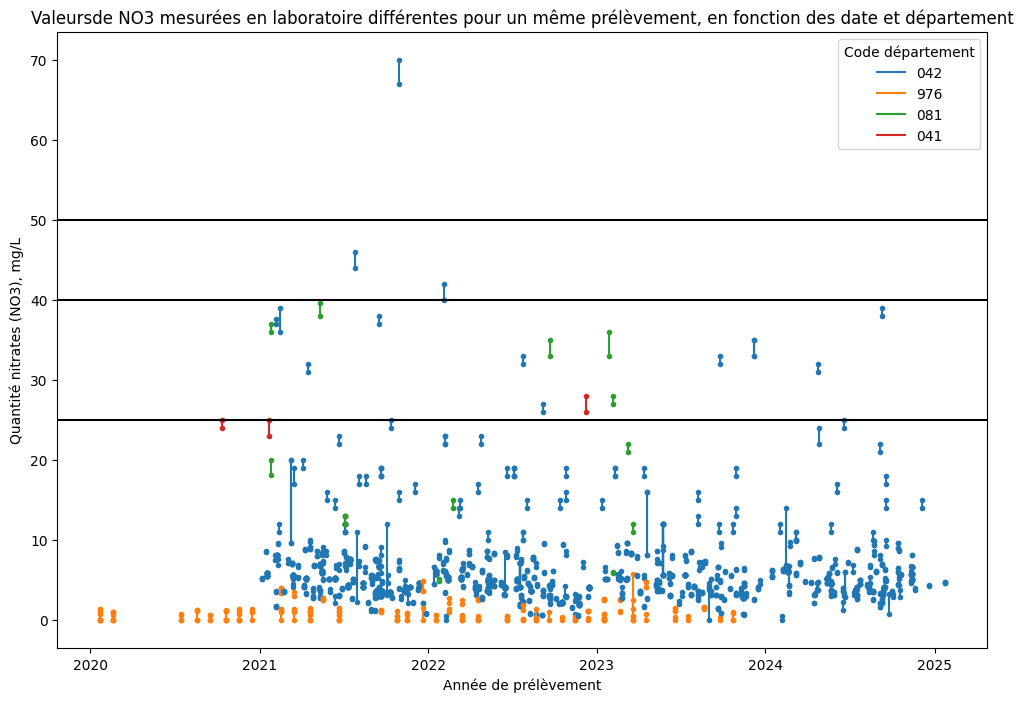

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 8))


cmap = {dpt: f"C{idpt}" for idpt, dpt in enumerate(dep_count.index)}

for iv, v in dfm.iterrows():
    plt.plot(
        [v["dateprel"]] * len(v["valtraduite"]),
        v["valtraduite"],
        ".-",
        color=cmap[v.cddept],
    )
plt.legend(
    title="Code département",
    handles=[Line2D([0], [0], label=k, color=v) for k, v in cmap.items()],
)

for seuil in [25, 40, 50]:
    plt.axhline(seuil, color="k", label="")

plt.ylabel("Quantité nitrates (NO3), mg/L")
plt.xlabel("Année de prélèvement")
plt.title(
    "Valeursde NO3 mesurées en laboratoire différentes pour un même prélèvement, en fonction des date et département"
)

## Conclusion

Dans ce Notebook, nous avons étudié les cas où un prélèvement avait été ré-analysé en laboratoire avec des résultats différents pour les catégories de polluants qui nous intéressent.

La grande majorité des divergences sont pour les nitrates (NO3), en particulier dans la Loire (42) et Mayotte (976).

Pour Mayotte (en orange), beaucoup de ré-analyses ont à la fois une valeur nulle et une valeur non-nulle, mais elles sont systématiquement sous le premier des seuils critiques (25 mh/L).
En outre le problème semble s'arrêter vers novembre 2023 (pas de cas ensuite).

Pour la Loire (en bleu), on est plutôt dans le cas où les réanalyses ont des valeurs proches (les segments verticaux sont courts);
il est très rare qu'on soit au-delà du premier seuil donc le cas n'est pas problématique (du moins, pas pour cela, des questions sont en suspens).

Concernant le Loir-et-Cher (en rouge), en revanche, les cas de réanalyse sont systématiquement proches du seuil.
"Tout se passe comme si" ces cas qui risquaient de lever une alerte avaient été réanalysés en espérant passer sous le seuil. 
On regarde donc finalement ce dernier cas pour voir si les ré-analyses ont été effectuées lorsque la première analyse était proche de 25.
Les dates d'analyse ne sont pas présentes mais on suppose que la valeur de referenceanl la plus élevée a été faite en second.
On se rend compte que la réanalyse est toujours la plus proche du seuil, et qu'aucun problème d'intégrité scientifique n'est à souligner.

In [14]:
pd.merge(dfprel, dfNO3).query("cddept=='041'")

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,moalib,referenceanl,cdparametresiseeaux,valtraduite
32,041,041000603,41167,VEUZAIN-SUR-LOIRE,None,None,None,04100094559,2020-10-12,09h09,SIAEP DU VAL DE CISSE (MONTEAUX),04100103675,NO3,24.0
33,041,041000603,41167,VEUZAIN-SUR-LOIRE,None,None,None,04100094559,2020-10-12,09h09,SIAEP DU VAL DE CISSE (MONTEAUX),04100103676,NO3,25.0
78,041,041000603,41167,VEUZAIN-SUR-LOIRE,None,None,None,04100095183,2021-01-21,14h10,SIAEP DU VAL DE CISSE (MONTEAUX),04100104488,NO3,23.0
79,041,041000603,41167,VEUZAIN-SUR-LOIRE,None,None,None,04100095183,2021-01-21,14h10,SIAEP DU VAL DE CISSE (MONTEAUX),04100104490,NO3,25.0
1258,041,041000487,41059,CONTROIS-EN-SOLOGNE (LE),041000230,CHATEAU D'EAU RTE DE SOINGS,100 %,04100101799,2022-12-09,08h48,MAIRIE DE CONTROIS-EN-SOLOGNE (LE),04100112608,NO3,28.0
1259,041,041000487,41059,CONTROIS-EN-SOLOGNE (LE),041000230,CHATEAU D'EAU RTE DE SOINGS,100 %,04100101799,2022-12-09,08h48,MAIRIE DE CONTROIS-EN-SOLOGNE (LE),04100112609,NO3,26.0
